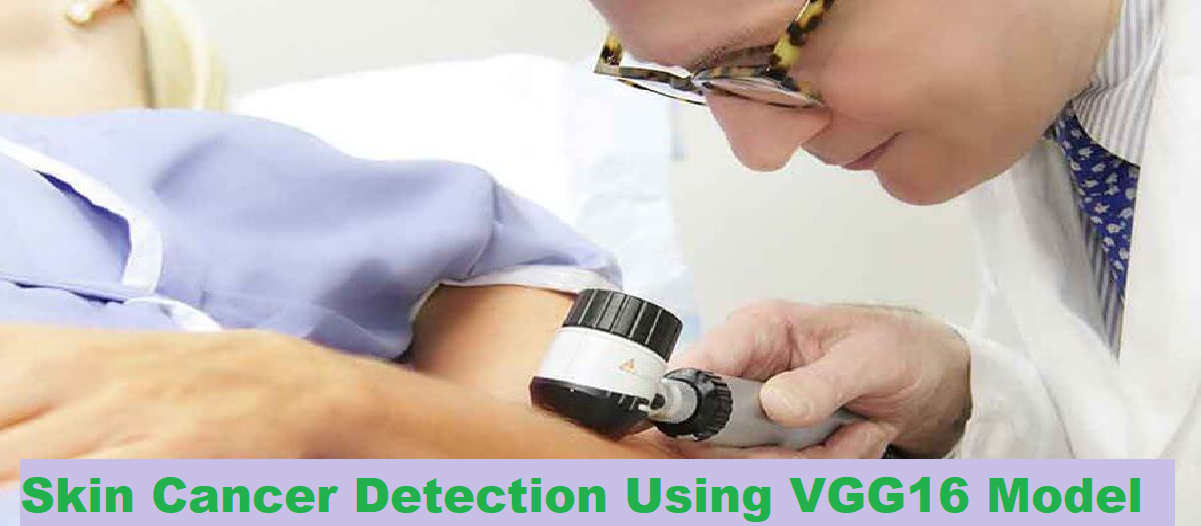

### Types of Skin cancer tumor
- A tumor is a cluster of abnormal cells. Depending on the types of cells in a tumor, it can be:
1. **Benign** : The tumor doesn’t contain cancerous cells.
2. **Malignant** : The tumor contains cancerous cells.

### Skin Cancer Tumor Type Classification

In [39]:
import os
import cv2
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from keras import backend as K
from keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Loading the Image Data

**Data Set**- 'https://drive.google.com/drive/folders/1JCCBiqSuLCGGxal4g1VpiqdraHc6OyXL?usp=sharing'

In [ ]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/AI & Deep Learning/Datasets/Skin_Cancer'
train_dir = '/content/drive/MyDrive/Colab Notebooks/AI & Deep Learning/Datasets/Skin_Cancer/train'
train_benign_dir = '/content/drive/MyDrive/Colab Notebooks/AI & Deep Learning/Datasets/Skin_Cancer/train/benign'
train_malign_dir = '/content/drive/MyDrive/Colab Notebooks/AI & Deep Learning/Datasets/Skin_Cancer/train/malignant'
test_dir = '/content/drive/MyDrive/Colab Notebooks/AI & Deep Learning/Datasets/Skin_Cancer/test'
test_benign_dir = '/content/drive/MyDrive/Colab Notebooks/AI & Deep Learning/Datasets/Skin_Cancer/test/benign'
test_malign_dir = '/content/drive/MyDrive/Colab Notebooks/AI & Deep Learning/Datasets/Skin_Cancer/test/malignant'
valid_dir = '/content/drive/MyDrive/Colab Notebooks/AI & Deep Learning/Datasets/Skin_Cancer/validation'
valid_benign_dir = '/content/drive/MyDrive/Colab Notebooks/AI & Deep Learning/Datasets/Skin_Cancer/validation/benign'
valid_malign_dir = '/content/drive/MyDrive/Colab Notebooks/AI & Deep Learning/Datasets/Skin_Cancer/validation/malignant'

In [ ]:
num_benign_train = len(os.listdir(train_benign_dir))
num_malignant_train = len(os.listdir(train_malign_dir))
num_benign_validaition = len(os.listdir(valid_benign_dir))
num_malignant_validation= len(os.listdir(valid_malign_dir))
num_benign_test = len(os.listdir(test_benign_dir))
num_malignant_test= len(os.listdir(test_malign_dir))

### Total Images in Each set of data

In [ ]:
print("Total Training Benign Images",num_benign_train)
print("Total Training Malignant Images",num_malignant_train)
print("--")
print("Total validation Benign Images",num_benign_validaition)
print("Total validation Malignant Images",num_malignant_validation)
print("--") 
print("Total Test Benign Images", num_benign_test)
print("Total Test Malignant Images",num_malignant_test)
total_train = num_benign_train+num_malignant_train
total_validation = num_benign_validaition+num_malignant_validation
total_test = num_benign_test+num_malignant_test
print("--")
print("Total Training Images",total_train)
print("--")
print("Total Validation Images",total_validation)
print("--")
print("Total Testing Images",total_test) 

Total Training Benign Images 1140
Total Training Malignant Images 937
--
Total validation Benign Images 300
Total validation Malignant Images 260
--
Total Test Benign Images 360
Total Test Malignant Images 300
--
Total Training Images 2077
--
Total Validation Images 560
--
Total Testing Images 660


### Resize images to (224,224) because VGG-16 only accepts that image size.

In [ ]:
IMG_SHAPE  = 224
batch_size = 32

### Preprocessing the Image data

### Rescaling and shuffling

In [ ]:
#Training set
image_gen_train = ImageDataGenerator(rescale = 1./255)
train_data_gen = image_gen_train.flow_from_directory(batch_size = batch_size,
                                                     directory = train_dir,
                                                     shuffle= True,
                                                     target_size = (IMG_SHAPE,IMG_SHAPE),
                                                     class_mode = 'binary')

#Validation set
image_generator_validation = ImageDataGenerator(rescale=1./255)
val_data_gen = image_generator_validation.flow_from_directory(batch_size=batch_size,
                                                              directory=valid_dir,
                                                              target_size=(IMG_SHAPE, IMG_SHAPE),
                                                              class_mode='binary')

#Test set
image_gen_test = ImageDataGenerator(rescale=1./255)
test_data_gen = image_gen_test.flow_from_directory(batch_size=batch_size,
                                                   directory=test_dir,
                                                   target_size=(IMG_SHAPE, IMG_SHAPE),
                                                   class_mode='binary')

Found 2077 images belonging to 2 classes.
Found 560 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [48]:
train_data_gen.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [49]:
train_data_gen.class_indices

{'benign': 0, 'malignant': 1}

In [ ]:
test_data_gen.class_indices

{'benign': 0, 'malignant': 1}

### Download VGG-16 weights
- VGG-16 is trained model with many classes, so if we use (top_layer = True), then we need to retrain it on all classes at which VGG-16 trained, but if we use (top_layer = False), then in retraining, we only need to add our training classes.

In [ ]:
pre_trained_model = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

58889256/58889256 [==============================] - 1s 0us/step


### Freeze the training layers of VGG-16. (because VGG-16, is already trained on huge data)

In [ ]:
for layer in pre_trained_model.layers:
    print(layer.name)
    layer.trainable = False

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


### Modify the last layer for our classes. We are going to add one max polling, one dense layer, one dropout, and one output with the last layer of VGG-16.

In [ ]:
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(2, activation='sigmoid')(x)

In [ ]:
### For “Multiclass classification”, change the last dense layer value with 3, and activation with softmax.
#x = tf.keras.layers.Dense(3, activation='softmax')(x)

### Merge the original VGG-16 layers, with our custom layers.

In [ ]:
model = tf.keras.Model(pre_trained_model.input, x)

### Compile the model

In [17]:
model.compile(optimizer='adam', loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [ ]:
### For “Multiclass classification”, change the loss with categorical_crossentropy.
#model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['acc'])

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Train the model

In [19]:
vgg_classifier = model.fit(train_data_gen, steps_per_epoch=(total_train//batch_size), 
                           epochs = 5, validation_data=val_data_gen, 
                           validation_steps=(total_validation//batch_size),
                           batch_size = batch_size, verbose = 1)

Epoch 1/5
64/64 [==============================] - 1750s 27s/step - loss: 0.6181 - accuracy: 0.7007 - val_loss: 0.5410 - val_accuracy: 0.7757
Epoch 2/5
64/64 [==============================] - 1734s 27s/step - loss: 0.4673 - accuracy: 0.7756 - val_loss: 0.4175 - val_accuracy: 0.8125
Epoch 3/5
64/64 [==============================] - 1716s 27s/step - loss: 0.3922 - accuracy: 0.8200 - val_loss: 0.3847 - val_accuracy: 0.8199
Epoch 4/5
64/64 [==============================] - 1715s 27s/step - loss: 0.3852 - accuracy: 0.8230 - val_loss: 0.4136 - val_accuracy: 0.7904
Epoch 5/5
64/64 [==============================] - 1733s 27s/step - loss: 0.3815 - accuracy: 0.8117 - val_loss: 0.3712 - val_accuracy: 0.8364


### Test our model on testing data.

In [31]:
result = model.evaluate(test_data_gen,batch_size=batch_size)
print("Test Loss : {}\nTest Accuracy : {}".format(result[0], result[-1]*100))

Test Loss : 0.35898587107658386
Test Accuracy : 83.93939137458801


### Lets Predict the Skin Cancer type for New data

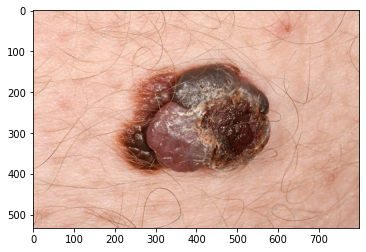

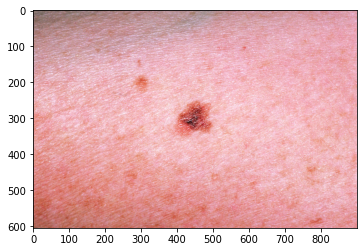

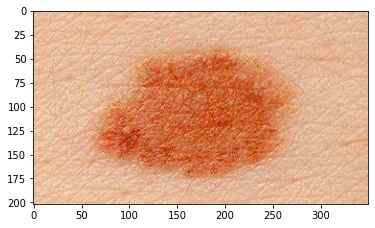

In [47]:
samp_dir='/content/drive/MyDrive/Colab Notebooks/AI & Deep Learning/Datasets/Skin_Cancer/sample'
paths=[samp_dir+"/1.jpg", samp_dir+"/2.jpg", samp_dir+"/3.jpeg"]

import matplotlib.pyplot as plt
for i in paths:
    plt.imshow(plt.imread(i))
    plt.show()

In [40]:
datagen=ImageDataGenerator(data_format=K.image_data_format())

samples=[]
def convert_to_image(X):
    '''Function to convert all Input Images to the STANDARD SIZE and create sample Dataset
    '''
    
    for f in paths:
        if os.path.isdir(f):
            continue
        img= PIL.Image.open(f)
        img =img.resize((IMG_SHAPE,IMG_SHAPE))
        img=np.array(img)
        samples.append(img)
    return samples
samples= np.array(convert_to_image(samples))
datagen.fit(samples)

In [54]:
predictions= model.predict(samples)

for i in range(len(predictions)):
    cls=np.argmax(predictions[i])
    if cls==1:
        print("Tumor type is Malignant")
    else:
        print("Tumor type is Benign")

1/1 [==============================] - 3s 3s/step
Tumor type is Malignant
Tumor type is Benign
Tumor type is Benign


### Conclusion:
1. **Loaded Images and Rescalled and Reshaped the Images, perform Image Preprocessing.**
2. **Download VGG16 pretrained model.**
3. **Trained the model adding the New images.**
4. **Tested the model on Test Images.**
5. **Predicted the class of tumor for new Images.**